# Dive into Deep Learning (DDL): Ch. 3.5-3.7. 

Complete Section 3.7.6 Exercise 1; include your plots in your weekly update.

In [4]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs) #random tensor for the input features of the dataset is made. The size of this tensor is the size of training + validation examples.
        noise = torch.randn(n, 1) * 0.01 
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05 #all weights initially 0.01, bias is 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

In [2]:
#L2 norm penality
def l2_penalty(w):
    return (w ** 2).sum() / 2 #square all terms in place and sum them

In [4]:
class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

In [5]:
#fits our model on the training set with 20 examples and evaluates it on the validation set with 100 examples.
data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

L2 norm of w: 0.009537017904222012


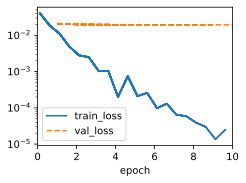

In [6]:
#3.7.6.1: lambda = 0, which disables the weight decay term. 
#This results in overfitting, reducing the training error but not the validation error
train_scratch(0)

L2 norm of w: 0.0013556692283600569


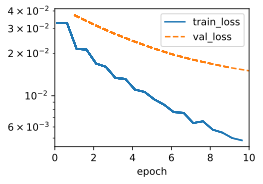

In [7]:
#3.7.6.1 continued: substantial weight decay of lambda = 3.
# training error increases but the validation error decreases --> regularization
train_scratch(3)

In [8]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

L2 norm of w: 0.014217971824109554


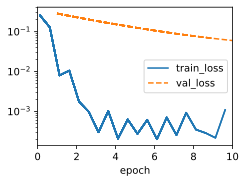

In [10]:
#weight decay in the update steps of the minibatch stochastic gradient descent algorithm
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

L2 norm of w: 0.0007039454067125916


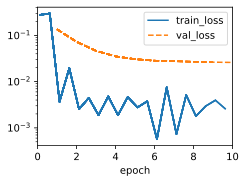

In [11]:
#Changing value of lambda further to 10
model = WeightDecay(wd=10, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))

# Dive into Deep Learning (DDL): Ch. 4.1-4.4. 

Complete Section 4.4.7 Exercise 5; include your plots in your weekly update. I recommend you run this in Colab to gain access to GPUs.

In [1]:
#4.1 Notes
#fully connected output layer: if the calculation of each output node in the output layer depends on every input
#normalization: transform values so that they add up to 1 by dividing each by their sum
#softmax: exponential function since the conditional class probability increases with an increased val in output later nodes, monotonic, nonnegative. exp(o)/sum of all exp(o)
#Cross entropy loss: minimizing the negative log-likelihood, l(y, yhat) = - sum over q classes (y*log yhat)
#In any exponential family model, the gradients of the log-likelihood is the difference between the probability assigned by our model (softmax result) and what actually happenend (one hot label vector)
#joint likelihood function: calculates the probability of observing all the data points simultaneously, assesses the "goodness of fit" of your model to the data, 
#       Joint Likelihood = Likelihood(x1) * Likelihood(x2) * ... * Likelihood(xn)

#4.2 Notes
#data iterator reads a minibatch of data (randomly shuffled training  examples) with size batch_size

In [12]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), #num_outputs = number of classes (10), #num_inputs for a 28by28 image is flattened 784, so W = 784by10, initalized with gaussian noise
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)  #1x10 row vector for biases

    def parameters(self):
        return [self.W, self.b]

In [13]:
#Maps how 
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X): #defines how the network maps each input to an output
    X = X.reshape((-1, self.W.shape[0])) #we flatten each 28by28 pixel image in the batch into a vector using reshape before passing the data through our model
    return softmax(torch.matmul(X, self.W) + self.b)

In [14]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean() #cross-entropy loss function by averaging over the logarithms of the selected predicted probabilities assigned to the true label

@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

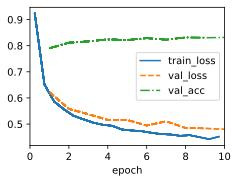

In [15]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10) #train the model with 10 epochs
#number of epochs (max_epochs), the minibatch size (batch_size), and learning rate (lr) are adjustable hyperparameters, not learned during our primary training loop, but still influence the performance of our model
#choose hyperparameter values based on the validation split of the data and then, ultimately, to evaluate your final model on the test split
trainer.fit(model, data)

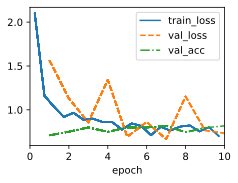

In [16]:
#4.4.7.5.1: Ploting how the validation loss changes when I increase the learning rate to 0.5.
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.5)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

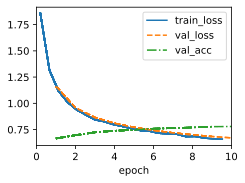

In [19]:
#4.4.7.5.2: Plotting the validation and training loss change when I decrease the minibatch size
data = d2l.FashionMNIST(batch_size=4096)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)